# Прогнозирование оттока клиентов оператора связи.

Необходимо научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# План работ 

- Загрузка и анализ данных.
    - Загрузить данные.
    - Привести названия колонок к стандартному виду.
    - Оценить типы данных и наличие пропусков.
- Первичная обработка данных и исследовательский анализ данных.
    - Объелинить данные в одну таблицу.
    - Заполнить пропуски.
    - Оченить кросскорреляцию.
    - Оценить влияние категориальных признаков на итоговый результат.
    - Разбить данные на обучающую и тестовую выборки.
    - Оценить дисбаланс классов.
- Оценить различные модели.
    - CatBoost, Random Forest, Logistic Regression.
    - Опимальные параметры подбирать с GridSearchCV.
    - Использовать метрику roc_auc.
    - Для кодирования категориальных признаков для Random Forest применить технику One Hot Encoding.
    - Для Logistic Regression применить масштабирование данных.
- Проверка лучшей модели на тестовой выборке.
    - Выбрать модель и параметры, показавшие наилучший результат.
    - Оценить roc_auc и accuracy на тестовой выборке.
    - Провести проверку модели на адекватность.



## Загрузка и анализ данных.

In [1]:
!pip install scikit-plot

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import scikitplot as skplt

import seaborn as sns
import matplotlib.pyplot as plt

import re



Загрузим данные и посмотрим на них.

In [3]:
try:
    contract = pd.read_csv('datasets/final_provider/contract.csv',index_col=0)
    internet = pd.read_csv('datasets/final_provider/internet.csv',index_col=0)
    personal  = pd.read_csv('datasets/final_provider/personal.csv',index_col=0)
    phone = pd.read_csv('datasets/final_provider/phone.csv',index_col=0)
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv',index_col=0)
    internet = pd.read_csv('/datasets/final_provider/internet.csv',index_col=0)
    personal  = pd.read_csv('/datasets/final_provider/personal.csv',index_col=0)
    phone = pd.read_csv('/datasets/final_provider/phone.csv',index_col=0)

Приведем названия колонок к стандартному виду.

In [4]:
dfs = [contract,internet,personal,phone]
for df in dfs:
    col_dict = {}
    for col in df.columns:
        col_dict[col] = '_'.join(re.split('(?<=.)(?=[A-Z])', col)).lower()
    df.rename(columns=col_dict,inplace=True)
internet.rename(columns={'streaming_t_v':'streaming_tv'},inplace=True)
for df in dfs:
    print(df.columns)

Index(['begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method',
       'monthly_charges', 'total_charges'],
      dtype='object')
Index(['internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')
Index(['gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')
Index(['multiple_lines'], dtype='object')


### Контракт

In [5]:
contract.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


Колонка `total_charges` строкового типа, хотя должна быть числом. Она содержит пробелы.  

In [7]:
contract.loc[contract['total_charges'] ==' ']

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


Это новые контракты, по ним видимо еще не было выплат. Заменим пробелы на нули.

In [8]:
contract.loc[contract['total_charges'] ==' ','total_charges'] = 0
contract['total_charges'] = contract['total_charges'].astype(float)

### Интернет

In [9]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   internet_service   5517 non-null   object
 1   online_security    5517 non-null   object
 2   online_backup      5517 non-null   object
 3   device_protection  5517 non-null   object
 4   tech_support       5517 non-null   object
 5   streaming_tv       5517 non-null   object
 6   streaming_movies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [10]:
internet.head()

,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


Тут все в порядке.

### Телефон.

In [11]:
phone.head()

,multiple_lines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [12]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   multiple_lines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


### Персональные данные

In [13]:
personal.head()

,gender,senior_citizen,partner,dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [14]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          7043 non-null   object
 1   senior_citizen  7043 non-null   int64 
 2   partner         7043 non-null   object
 3   dependents      7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


## Первичная обработка данных.

In [15]:
data = contract.join([internet,personal,phone])
data.head()

,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   begin_date         7043 non-null   object 
 1   end_date           7043 non-null   object 
 2   type               7043 non-null   object 
 3   paperless_billing  7043 non-null   object 
 4   payment_method     7043 non-null   object 
 5   monthly_charges    7043 non-null   float64
 6   total_charges      7043 non-null   float64
 7   internet_service   5517 non-null   object 
 8   online_security    5517 non-null   object 
 9   online_backup      5517 non-null   object 
 10  device_protection  5517 non-null   object 
 11  tech_support       5517 non-null   object 
 12  streaming_tv       5517 non-null   object 
 13  streaming_movies   5517 non-null   object 
 14  gender             7043 non-null   object 
 15  senior_citizen     7043 non-null   int64  
 16  partner       

In [17]:
np.unique(data.index == contract.index)

array([ True])

7043 элемента в таблице contracts и в таблице data, и у них одинаковые индексы, значит из contracts все данные сохранились. Поскольку целевой признак содержится только в contracts, то даже, если мы потеряем какие-то данные из других таблиц, то на итоговый результат это не повлияет. 

In [19]:
data=data.reset_index()
data.head()

,customerID,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


In [20]:
data.duplicated().sum()

0

Создадим целевой признак, если у клиента есть значение в колонке end_date, то значит он ушёл. Заменим `No` в end_date на `2020-02-01`. Посчитаем длительность действия контракта. Даты удалим.

In [24]:
data['target'] = 1
data.loc[data['end_date']=='No','target'] = 0
data.loc[data['end_date']=='No','end_date'] = '2020-02-01'
data['duration'] = (pd.to_datetime(data['end_date'],format='%Y-%m-%d')-pd.to_datetime(data['begin_date'],format='%Y-%m-%d')).astype('timedelta64[M]')
data = data.drop(columns=['begin_date','end_date'])
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target,duration
0,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,0,1.0
1,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0,34.0
2,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1,2.0
3,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN,0,45.0
4,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1,2.0


Посмотрим на пропуски, которые появились в результате объединения. Поскольку колонки с телефонией не применимы к интернету и наоборот, заполним их значениями *NA* - Not Aplicable

In [25]:
data.isna().sum()

type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
target                  0
duration                0
dtype: int64

In [26]:
internet_columns = internet.columns
data.loc[:,internet_columns] = data.loc[:,internet_columns].fillna('NA')

data['multiple_lines'] = data['multiple_lines'].fillna('NA')


### Линейная кросскорреляция.

Посмотрим на матрицу корреляции.

<AxesSubplot:>

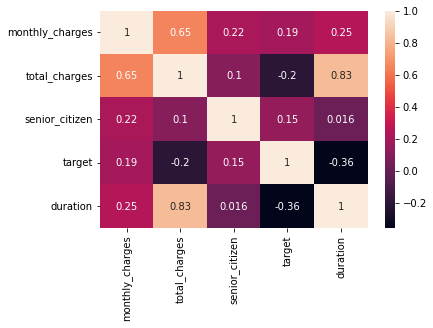

In [27]:
sns.heatmap(data.corr(),annot=True)

Наблюдается значительная корреляци между продолжительностью контракта и суммарными выплатами, что вобщем-то логично. Удалим суммарные выплаты из данных, но перед этим создадим новую переменную, которая равна разнице суммарных выплат и ежемесячных выплат, умноженных на длительность контракта.  

In [28]:
data['random_pay'] = data['total_charges'] - data['monthly_charges']*data['duration']

In [29]:
data.drop(columns=['total_charges'], inplace=True)

<AxesSubplot:>

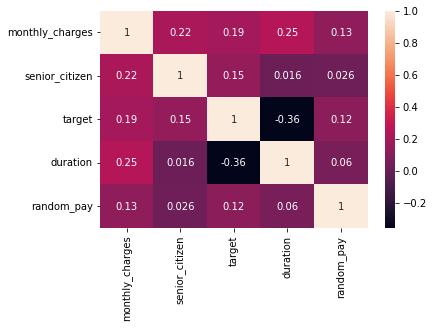

In [30]:
sns.heatmap(data.corr(),annot=True)

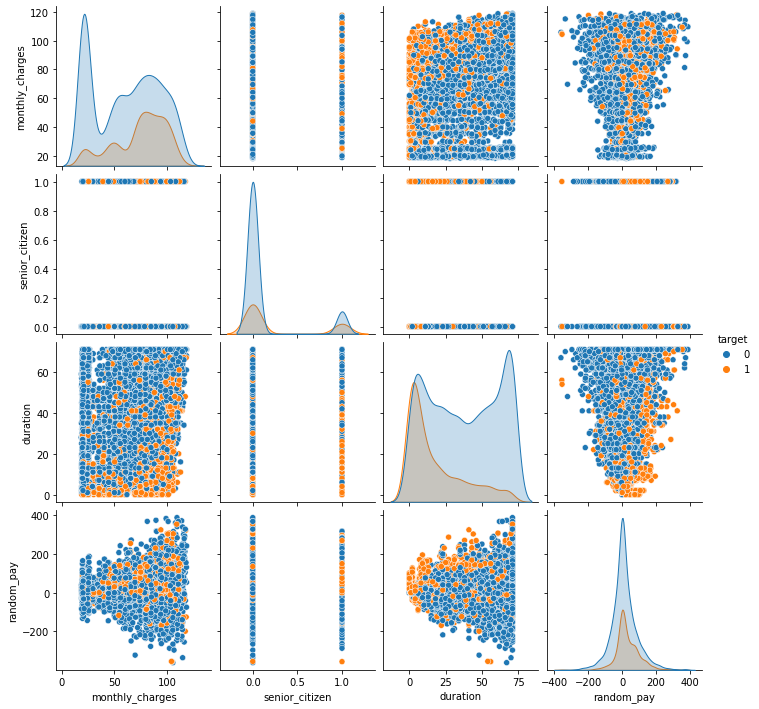

In [31]:
sns.pairplot(data,hue='target')

- В основном уходят клиенты, у которых контракты длятся долго, если срок контракта ментьше ~2 лет, то остается и уходит примерно одинаковая доля клиентов, но с ростом продолжительности доля остающихся клиентов падает, а ушедших растет.
- Чаще уходят те, у кого большие месячные выплаты.

### Категориальные признаки

Разделим категориальные и числовые признаки.

In [32]:
num_columns = ['monthly_charges','duration','random_pay']
cat_columns = list(set(data.columns) - set(num_columns) - set(['target']))
cat_columns

['partner',
 'tech_support',
 'paperless_billing',
 'internet_service',
 'device_protection',
 'dependents',
 'streaming_movies',
 'gender',
 'streaming_tv',
 'multiple_lines',
 'type',
 'senior_citizen',
 'payment_method',
 'online_security',
 'online_backup']

Посмотрим на категориальные признаки.

In [33]:
len(cat_columns)

15

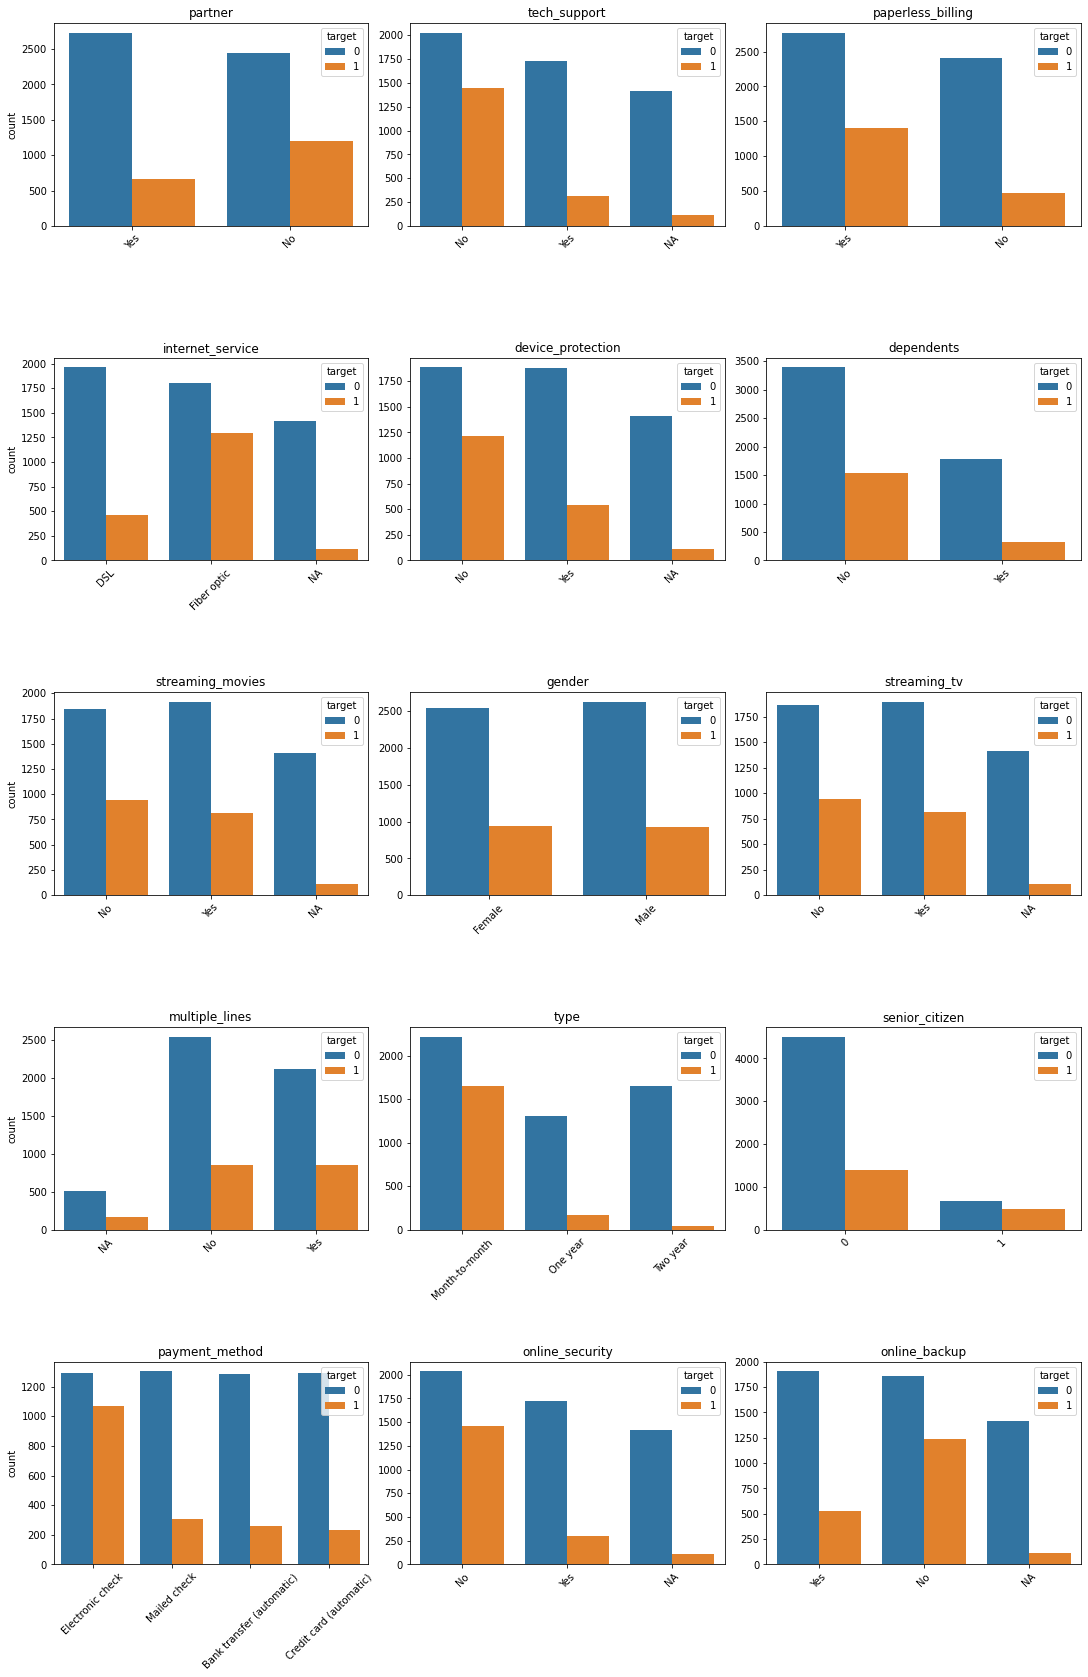

In [34]:
fig, axes = plt.subplots(5, 3, figsize=(15, 22))

fig.tight_layout() 
plt.subplots_adjust(hspace=0.65)
for i in range(3):
    for j in range(5):
        sns.countplot(data=data,x=cat_columns[3*j+i],hue='target',ax=axes[j,i])
        axes[j,i].set_title(cat_columns[3*j+i])
        axes[j,i].set(xlabel=None)
        if i>0:
            axes[j,i].set(ylabel=None)
        axes[j,i].tick_params(axis='x', rotation=45)

- Мужчины и женщины одинаково часто уходят и остаются, этот признак не несет полезной информации. Удалим его.
- Чаще уходят клиенты с помесячной оплатой.
- Доля ушедших клиентов среди senior_citizen меньше, чем доля ушедших клиентов среди всех остальных.
- Больше бездетных клиентов, соответственно и уходят они чаще.
- Те, кто не пользуется техподдержкой, уходят занчительно чаще, чем те, кто пользуются.
- Те, у кого оптоволокно, уходят чаще, чем те, у кого DSL.
- Семейные уходят реже, чем те, у кого нет партнера.


### Дисбаланс классов.

Посмотрим на дисбаланс классов.

In [35]:
data['target'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: target, dtype: float64

### Разбиение на обучающую и тестовую выборки.

Выделим целевой признак

In [36]:
X = data.drop(columns=['target'])
y = data['target']

Разделим данные на обучающую и тестовую выборки.

In [37]:
RANDOM_STATE = 121222

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=RANDOM_STATE)

## Catboost

In [39]:
train_pool = Pool(X_train, y_train, cat_features=cat_columns)
test_pool = Pool(X_test, cat_features=cat_columns) 

 Посчитаем веса для классов, чтобы учесть дисбаланс при обучении.

In [40]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.6806146115191342, 1: 1.8841626538255751}

In [41]:
model = CatBoostClassifier(logging_level='Silent',
                           eval_metric='AUC:hints=skip_train~false',
                           class_weights=[1.88,0.68],
                           random_state =RANDOM_STATE)

Ниже изначальные параметры для grid search, чтобы ускорить время работы, в итоговой версии их меньше.

``` python
grid = {'learning_rate': [0.001,0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations':[50,100,500, 1000],
        'l2_leaf_reg': [None,1, 3, 5,],
        }

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.03}
roc_auc = 0.8643609646872065
```

In [42]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6],
        'iterations':[1000],
        'l2_leaf_reg': [3]
        }

In [43]:
cb_search_result = model.grid_search(grid, 
                                       train_pool,
                                       cv=3, 
                                       verbose=False, 
                                       plot=True,
                                       partition_random_seed=RANDOM_STATE)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Посмотрим на важность входных параметров.

<AxesSubplot:xlabel='feature_importance', ylabel='feature_names'>

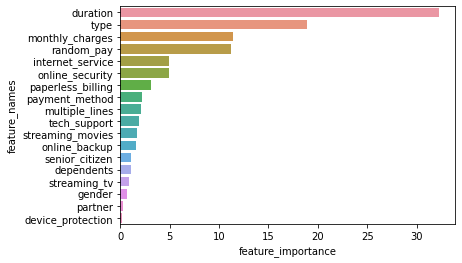

In [44]:
fi = pd.DataFrame({'feature_importance': model.get_feature_importance(train_pool), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
sns.barplot(data=fi, x="feature_importance", y="feature_names")

Похоже что 4 последних можно было удалить.

In [45]:
cb_best_params = cb_search_result['params']
cb_best_params

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.03}

In [46]:
cb_best_score = max(cb_search_result['cv_results']['test-AUC-mean'])
cb_best_score

0.8643609646872065

## Random Forest

Закодируем категориальные признаки отдельно.

In [47]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
        transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_columns)])
preprocessor.fit(X_train)
X_train_sc_ohe = preprocessor.transform(X_train)
X_test_sc_ohe = preprocessor.transform(X_test)

In [48]:
forest = RandomForestClassifier(random_state=RANDOM_STATE,class_weight='balanced')

In [49]:
parameters = {'n_estimators':[50,100,500], 'max_depth':[5, 10,15]}

In [50]:
forest_search_results = GridSearchCV(forest, parameters,cv=3,scoring='roc_auc')

``` python
forest_search_results.fit(X_train_ohe,y_train)
```

In [51]:
forest_search_results.fit(X_train_sc_ohe,y_train)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=121222),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 500]},
             scoring='roc_auc')

In [52]:
forest_best_score = forest_search_results.best_score_
forest_best_score

0.848733129583878

In [53]:
forest_best_params = forest_search_results.best_params_
forest_best_params

{'max_depth': 10, 'n_estimators': 500}

## Logistic Regression

Попробуем подобрать наилучщий метод и силу регуляризации.

In [54]:
lr_pram_grid = {
    'penalty':['l1','l2'],
    'C':[10, 1, .1, 0.05,.01,.001]
}

In [55]:
reg = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear',class_weight='balanced')
reg_search_results = GridSearchCV(reg, lr_pram_grid,cv=3,scoring='roc_auc')

``` python
reg_search_results.fit(X_train_ohe,y_train)
```

In [56]:
reg_search_results.fit(X_train_sc_ohe,y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=121222,
                                          solver='liblinear'),
             param_grid={'C': [10, 1, 0.1, 0.05, 0.01, 0.001],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [57]:
reg_best_score = reg_search_results.best_score_
reg_best_score

0.8519154307114721

In [58]:
reg_best_params = reg_search_results.best_params_
reg_best_params

{'C': 0.1, 'penalty': 'l2'}

## Проверка на тестовой выборке

Сравним результаты всех моделей.

In [59]:
pd.DataFrame.from_dict({'CatBoost':cb_best_score,'RandomForest':forest_best_score,'LogisticRegression':reg_best_score},columns=['AUC'],orient='index').sort_values(by='AUC',ascending=False)

,AUC
CatBoost,0.864361
LogisticRegression,0.851915
RandomForest,0.848733


Наилучший результат показал CatBoost, проверим как он сработает на тестовой выборке.

In [60]:
cb_best_params

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.03}

In [61]:
cb_model =CatBoostClassifier(logging_level='Silent',
                           eval_metric='AUC:hints=skip_train~false',
                           class_weights=[1.88,0.68],
                           random_state =121222)
cb_model.set_params(**cb_best_params)

In [62]:
cb_model.fit(train_pool)

In [63]:
roc_auc_score(y_test, cb_model.predict_proba(test_pool)[:, 1])

0.8661322724880771

Значение roc_auc ~0.866, а если бы мы предсказали, что все клиенты остаются, то оно бы было 0.5, поэтому наша модель имеет предсказательну силу.

Посмотрим на значение accuracy.

In [64]:
accuracy_score(y_test,  cb_model.predict(test_pool))

0.807495741056218

In [65]:
accuracy_score(y_test,  np.zeros(len(y_test)))

0.7348097671777399

Значение accuracy тоже выше, чем, если бы мы предсказали, что все клиенты остаются.

## Отчёт.

### Постановка задачи

Прогноз оттока клиентов «Ниединогоразрыва.ком». В ходе работ необходимо подготовить и проанализировать данные, выбрать наилучшую модель и параметры для нее. Среди рассматриваемых моделей должен быть градиентный бустинг, простая модель, например логистическая регрессия и классическая модель, например случайный лес.

### Основные шаги.

В работе были выполнены следующие шаги:

**Этап загрузки и оценки данных:**

Загрузил данные, привел названия колонок к стандартному виду, заполнил пропуски в колонке c сумарными выплатами нулями, потому что это были новые контракты, по которым выплат еще не было, привел данные к соответсвующему виду, посчитал длительность действия контракта, выделил целевой признак по дате окончания контракта, удалил колонки с датами.

**На этапе исследовательского анализа данных:**

Объединил данные в одну таблицу, разделил категориальные и количественные признаки, проверил корреляцию между количественными признаками. Наблюдалась корреляция между между длительностью контракта, ежемесячными выплатами и суммарными выплатами, чтобы этого избежать, я вычел из суммарных выплат ежемесячные выплаты умноженные на длительность контракта и удалил колонку с сумарными выплатами. Затем построил графики того, как соотносятся категориальные признаки с целевым показателем. Оценил дисбаланс классов. Разделил данные на обучающую и тестовую выборку с учетом дисбаланса, параметр `strtified=True`, размер тестовой выборки 25 % от всех данных.

**Этап подбора модели и параметров:**

Били рассмотрены 3 модели: CatBoost, RandomForest и LogisticRegression. Во всех моделях использовался метод балансировки весов классов. Подбор параметров осуществлялся через GridSearchCV. Для RandomForest и LogisticRegression категориальные признаки были закодированны методом One Hot Encoding, а для количественных было применено масштабирование StandardScaller. Для оценки моделей использовалась метрика roc_auc.

**Этап проверки модели на тестовых данных:**

Наилучший результат показал CatBoost. roc_auc на тестовых данных была близка к roc_auc на этапе подбора параметров. roc_auc и accuracy прошли проверку на адекватность и показали, что предсказательная способность модели выше, чем если бы мы для прогноза использовали только нулевой класс.

`RANDOM_STATE = 121222`


### CatBoost

#### Веса для классов.

Немного неожиданными оказались значения весов для дисбаланса классов. Если дисбаланс классов ~ 0.7/0.3, то веса оказались такими:

In [66]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weights[::-1]

array([1.88416265, 0.68061461])

#### Наилучшие параметры модели и итоговые показатели

В результате подбора коэффициентов были подобраны сдедующие значения:

In [67]:
cb_best_params

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.03}

Было получено следующее значение метрики roc_auc

In [68]:
cb_best_score

0.8643609646872065

На тестовой выборке значение roc_auc даже оказалось чуть-чуть больше.

In [69]:
roc_auc_score(y_test, cb_model.predict_proba(test_pool)[:, 1])

0.8661322724880771

И значение accuracy на тестовой выборке, тоже оказалось довольно высоким.

In [70]:
accuracy_score(y_test,  cb_model.predict(test_pool))

0.807495741056218

#### Важность параметров

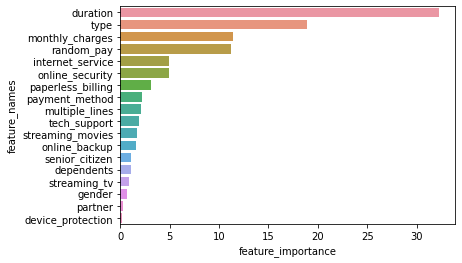

In [71]:
fi = pd.DataFrame({'feature_importance': cb_model.get_feature_importance(train_pool), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)
sns.barplot(data=fi, x="feature_importance", y="feature_names")
plt.show()

Самыми важными параметрами оказались: Продолжительность контракта, тип контракта, ежемесячные выплаты, и разница сумарных выплат и месячных выплат, умноженных на продолжительность. Отчасти это было видно на этапе первичной обработки данных, хотя важность не всех параметров была очевидна.

#### Визуализайия ROC

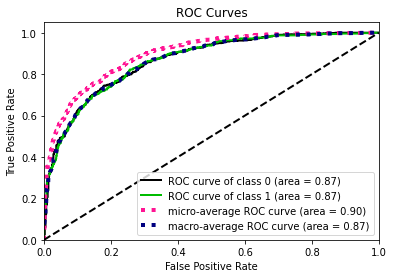

In [72]:
y_true = y_test
y_probas =  cb_model.predict_proba(test_pool)
skplt.metrics.plot_roc(y_true, y_probas)
plt.show()

### Вывод

 - Наилучший результат показал CatBoost. Для прогноза оттока клиентов рекомендуется использовать его. Значение метрики roc_auc на тестовой выборке составило 0.87, что даже немного выше, чем при обучении и кроссвалидации.
 - На втором месте оказалась логистическая регрессия. В отличие от CatBoost она простая и быстро работает, возможно имеет смысл рассмотреть и эту модель для классификации.